<a href="https://colab.research.google.com/github/Misheal-22/Music-Genre-Classification-Image-based---Spectrogram-CNN-/blob/main/MusicGenreClassifierImageBased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa
import numpy as np
import os
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: misheal22
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification


100%|██████████| 1.21G/1.21G [00:11<00:00, 118MB/s]


In [7]:
DATA_PATH = "/content/gtzan-dataset-music-genre-classification/Data/genres_original"

SAFE AUDIO LOADER

In [5]:
def safe_load(file_path, target_sr=22050):
    try:
        y, sr = sf.read(file_path, dtype='float32')
        if sr != target_sr:
            y = librosa.resample(y.T, orig_sr=sr, target_sr=target_sr)
        return y, target_sr
    except Exception:
        try:
            y, sr = librosa.load(file_path, sr=target_sr, duration=30)
            return y, sr
        except Exception as e:
            print(f"[WARN] Could not load {file_path}: {e}")
            return None, None

CONVERT AUDIO -> MEL SPECTROGRAM

In [8]:
def extract_spectrogram(file_path, n_mels=128, n_fft=2048, hop_length=512):
    y, sr = safe_load(file_path)
    if y is None:
        return None
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                       n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db

genres = os.listdir(DATA_PATH)
spectrograms, labels = [], []

for g in genres:
    genre_path = os.path.join(DATA_PATH, g)
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            file_path = os.path.join(genre_path, file)
            spec = extract_spectrogram(file_path)
            if spec is not None:
                spectrograms.append(spec)
                labels.append(g)

/tmp/ipython-input-1356925665.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=target_sr, duration=30)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


[WARN] Could not load /content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 


PAD/TURNACATE SPECTROGRAMS TO FIXED LENGTH

In [9]:
max_len = 660  # adjust depending on dataset (time dimension)
X = []
for spec in spectrograms:
    if spec.shape[1] < max_len:
        pad = np.zeros((spec.shape[0], max_len - spec.shape[1]))
        spec = np.hstack((spec, pad))
    else:
        spec = spec[:, :max_len]
    X.append(spec)

X = np.array(X)
X = X[..., np.newaxis]

ENCODE LABELS

In [10]:
le = LabelEncoder()
y = le.fit_transform(labels)
y = tf.keras.utils.to_categorical(y, num_classes=len(le.classes_))

TRAIN-TEST SPLIT

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

CNN MODEL

In [12]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, max_len, 1)),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TRAIN

In [13]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - accuracy: 0.1084 - loss: 656.3148 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.1050 - loss: 2.3024 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.1066 - loss: 2.3045 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.1134 - loss: 2.2979 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.0849 - loss: 2.3053 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.1009 - loss: 2.3059 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.1079 - loss: 2.3021 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.1139 - loss: 2.3017 - val_accuracy: 0.1000

EVALUATE

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step

=== CNN Results ===
              precision    recall  f1-score   support

       blues       0.38      0.15      0.21        20
   classical       0.68      0.65      0.67        20
     country       0.25      0.15      0.19        20
       disco       0.20      0.45      0.28        20
      hiphop       0.20      0.30      0.24        20
        jazz       0.62      0.40      0.48        20
       metal       0.34      0.50      0.41        20
         pop       0.10      0.15      0.12        20
      reggae       0.18      0.10      0.13        20
        rock       0.00      0.00      0.00        20

    accuracy                           0.28       200
   macro avg       0.30      0.29      0.27       200
weighted avg       0.30      0.28      0.27       200



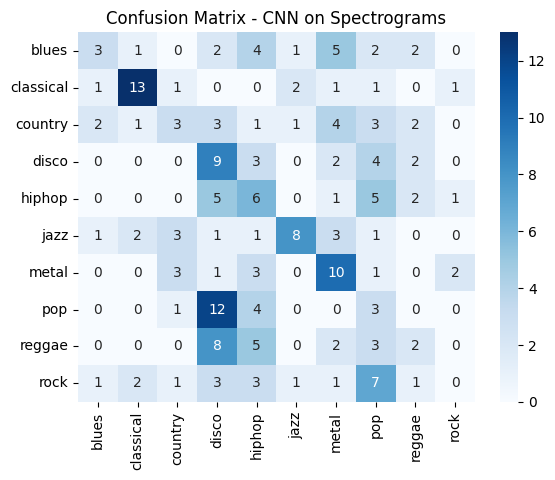

In [14]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== CNN Results ===")
print(classification_report(y_true, y_pred, target_names=le.classes_))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - CNN on Spectrograms")
plt.show()